In [1]:
df = pd.read_csv('Mall_Customers.csv', index_col='CustomerID')

In [2]:
df.head(5)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [3]:
df.corr()

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.012398,1.000000,0.009903
Spending Score (1-100),-0.327227,0.009903,1.000000


Annual Income と Spending Scoreに相関がないのか意外やな

In [4]:
%matplotlib inline

In [5]:
from mpl_toolkits.mplot3d import Axes3D

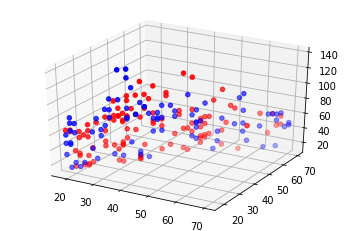

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
df_male = df[df.Gender=='Male']
df_female = df[df.Gender=='Female']
ax.scatter(df_male.Age, df_male.iloc[:, 1], df_male.iloc[:, 2], c='b')
ax.scatter(df_female.Age, df_female.iloc[:, 1], df_female.iloc[:, 2], c='r')
plt.show()

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm
import sklearn.preprocessing as preproc

In [8]:
df['Gender_'] = pd.get_dummies(df.Gender).Male

In [9]:
scaled = preproc.StandardScaler().fit_transform(df.drop(['Gender'], axis=1))

/Users/mac/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/mac/miniconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [10]:
plt.close()

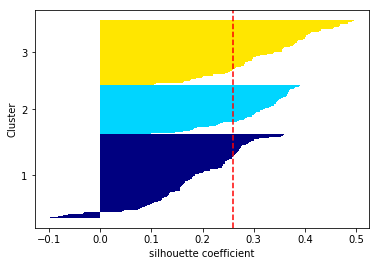

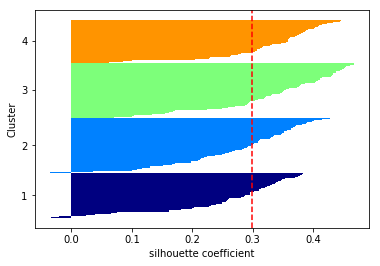

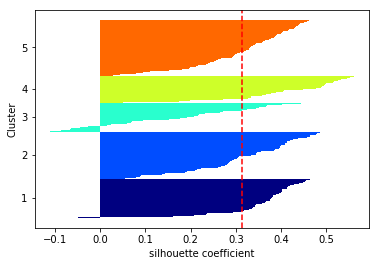

In [11]:
models = []
for i in range(3,6):
    n_clusters = i
    km = KMeans(n_clusters=n_clusters)
    y_km = km.fit_predict(scaled)
    cluster_labels = np.unique(y_km) 

    # シルエット係数を計算
    silhouette_vals = silhouette_samples(scaled, y_km)
    y_ax_lower, y_ax_upper= 0,0
    yticks = []

    for i,c in enumerate(cluster_labels):
            c_silhouette_vals = silhouette_vals[y_km==c]
            c_silhouette_vals.sort()
            y_ax_upper += len(c_silhouette_vals) 
            color = cm.jet(float(i)/n_clusters)
            plt.barh(range(y_ax_lower,y_ax_upper), c_silhouette_vals, height=1.0, color=color) 
            yticks.append((y_ax_lower+y_ax_upper)/2)  
            y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals) 
    plt.axvline(silhouette_avg,color="red",linestyle="--")
    plt.yticks(yticks,cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('silhouette coefficient')
    plt.show()
    models.append(km)

試しにクラスター数4のときを詳しく見てみる

In [12]:
km4 = models[1]

In [13]:
km4.cluster_centers_

array([[-0.80259081,  0.16692764,  0.56765749,  1.12815215],
       [ 0.64256818, -0.09498735, -0.59494042, -0.88640526],
       [-0.75047453, -0.00501655,  0.6979562 , -0.88640526],
       [ 0.98044981, -0.04445407, -0.72822025,  1.12815215]])

In [14]:
centers = pd.DataFrame(km4.cluster_centers_, columns=df.columns[1:])

In [15]:
centers

,Age,Annual Income (k$),Spending Score (1-100),Gender_
0,-0.802591,0.166928,0.567657,1.128152
1,0.642568,-0.094987,-0.594940,-0.886405
2,-0.750475,-0.005017,0.697956,-0.886405
3,0.980450,-0.044454,-0.728220,1.128152


Gender_を見ると
- 0,3はMale、1,2はFemale
- 他のカラムはどうだろうという感じ=>3Dプロットしてみる

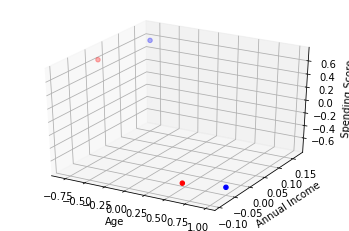

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
center_male = centers.loc[[0,3], :]
center_female = centers.loc[[1,2], :]
ax.scatter(center_male.Age, center_male.iloc[:, 1], center_male.iloc[:, 2], c='b')
ax.scatter(center_female.Age, center_female.iloc[:, 1], center_female.iloc[:, 2], c='r')
ax.set_xlabel("Age")
ax.set_ylabel("Annual Income")
ax.set_zlabel("Spending Score")
plt.show()

- 「若い方年齢層のクラスタ2つのspending scoreが高い」という意外な結果

In [17]:
silhouette_score(scaled, km4.predict(scaled))

0.29895590180505627

silhouette score は1に近づくほど良いがかなり低い値となっている。
そもそもKMeansでクラスタリングするのが難しそうな気がしている